<a href="https://colab.research.google.com/github/sharma18b/Image-Captioning/blob/main/CNN%20and%20RNN/InceptionV3_%2B_GRU_%2B_bahdanau_attention_on_Flickr30k_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!pip install -U nltk
os.environ['KAGGLE_CONFIG_DIR']='/content/'

In [155]:
#!kaggle datasets download -d 'hsankesara/flickr-image-dataset'


  #  ******************

  # bhaiya hr model ko chalane ke pehle database change kr dena / means hr baar 
  # shuru se kyuki ye images wale folder kuch 
  # npy files daalega jo hr model me alag banegi

  # *************************

In [156]:
#!unzip  flickr-image-dataset

In [4]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [5]:
# Download caption annotation files
annotation_folder = '/flickr30k_images/'
# Download image files
image_folder = '/flickr30k_images/flickr30k_images/'
PATH = os.path.abspath('.') + image_folder

In [6]:
dir_Flickr_text = "/content/flickr30k_images/results.csv"

In [7]:
import pandas as pd

In [8]:
annotation_file = os.path.abspath('.') + annotation_folder + 'results.csv'
file = open(annotation_file,'r')
text = file.read()
file.close()
#df_bonus = pd.read_csv(annotation_file)

In [9]:
df = pd.read_csv('/content/flickr30k_images/results.csv',
                   sep = '|',
                   engine = 'python')

In [10]:
colx = list()
for col in df.columns:
  colx.append(col);
  print(col)

image_name
 comment_number
 comment


In [11]:
print(colx[:3])

['image_name', ' comment_number', ' comment']


In [12]:
total_captions_in_f30k = len(df['image_name'])
print(total_captions_in_f30k)

158915


In [14]:
print(df[' comment'][0])

 Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [15]:
image_path_to_caption = collections.defaultdict(list)
for val in range(total_captions_in_f30k):
  caption = f"<start> {df[' comment'][val]} <end>"
  image_path = PATH + df['image_name'][val]
  image_path_to_caption[image_path].append(caption)

In [198]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:1000]
print(len(train_image_paths))

1000


In [199]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start>  A middle-aged woman is getting her hair done in a barber shop with polka-dotted walls . <end>


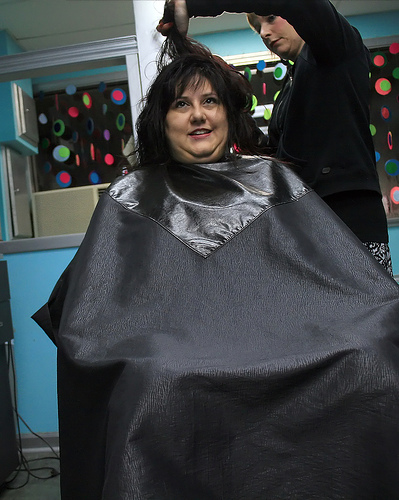

In [200]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [334]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [335]:

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [336]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 63/63 [00:15<00:00,  3.96it/s]


In [337]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [338]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [339]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [340]:
print(train_captions[:3])
print(train_seqs[:3])

['<start>  A middle-aged woman is getting her hair done in a barber shop with polka-dotted walls . <end>', '<start>  A woman getting a styling cut from a female hair stylist . <end>', '<start>  A woman sitting and getting a haircut by another woman . <end>']
[[3, 2, 180, 381, 13, 10, 210, 41, 87, 1397, 5, 2, 1745, 499, 12, 584, 1746, 2373, 4], [3, 2, 13, 210, 2, 2374, 986, 64, 2, 195, 87, 2375, 4], [3, 2, 13, 29, 8, 210, 2, 783, 44, 67, 13, 4]]


In [341]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

#Splitting 

In [342]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [343]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(4000, 4000, 1000, 1000)

In [344]:
print('image _ name _ train ' )
print(img_name_train[0:3])
print('cap _ train ' )
print(cap_train[0:3])
print('image _ name _ val ' )
print(img_name_val[0:3])
print('cap _ train ' )
print(cap_val[0:3])

image _ name _ train 
['/content/flickr30k_images/flickr30k_images/2070831523.jpg', '/content/flickr30k_images/flickr30k_images/2070831523.jpg', '/content/flickr30k_images/flickr30k_images/2070831523.jpg']
cap _ train 
[array([  3,   6,  31,  10,  20,   2,  57, 199,   8, 207,  53, 262, 205,
        41, 102,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32), array([  3,   2, 195,  12,   2,  25, 496,   8,   2, 207,  78,  41, 102,
         4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32), array([  3,   2,  13, 205,  41, 102,  38,   6,  34,   5,   6, 799,   4,
         0,   0,  

In [345]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [346]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [347]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#Model Design 

In [348]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [349]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [350]:

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [351]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [352]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [353]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [354]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#Training

In [355]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [356]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [357]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9606
Epoch 1 Loss 1.361773
Time taken for 1 epoch 178.21 sec

Epoch 2 Batch 0 Loss 1.2468
Epoch 2 Loss 1.210597
Time taken for 1 epoch 38.42 sec

Epoch 3 Batch 0 Loss 1.1158
Epoch 3 Loss 1.102906
Time taken for 1 epoch 38.00 sec

Epoch 4 Batch 0 Loss 1.0296
Epoch 4 Loss 1.027342
Time taken for 1 epoch 38.11 sec

Epoch 5 Batch 0 Loss 0.9677
Epoch 5 Loss 0.968837
Time taken for 1 epoch 38.08 sec

Epoch 6 Batch 0 Loss 0.8693
Epoch 6 Loss 0.905423
Time taken for 1 epoch 38.59 sec

Epoch 7 Batch 0 Loss 0.8684
Epoch 7 Loss 0.844692
Time taken for 1 epoch 38.02 sec

Epoch 8 Batch 0 Loss 0.8001
Epoch 8 Loss 0.788736
Time taken for 1 epoch 38.10 sec

Epoch 9 Batch 0 Loss 0.7355
Epoch 9 Loss 0.731073
Time taken for 1 epoch 38.02 sec

Epoch 10 Batch 0 Loss 0.6367
Epoch 10 Loss 0.680181
Time taken for 1 epoch 38.07 sec

Epoch 11 Batch 0 Loss 0.5647
Epoch 11 Loss 0.627703
Time taken for 1 epoch 41.35 sec

Epoch 12 Batch 0 Loss 0.5509
Epoch 12 Loss 0.581834
Time taken for 1 ep

In [362]:
def evaluate(image):
    attention_plot = np.zeros((max_length,attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        #print(len(attention_weights.shape))
        #print(attention_plot[i].shape)
        #print('hell')
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [363]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a gray haired man is playing an accordion while squatting against a cement wall with a crowd of people in the background <end>
Prediction Caption: a lady sitting on a court getting ready to a blue top and with his face <end>


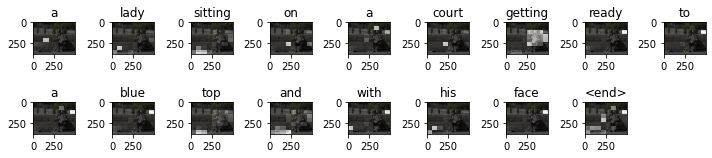

In [364]:

# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [365]:
decoder.save_weights('decoder InceptionV3 + GRU + BahdanauAttention .h5')
encoder.save_weights('encoder InceptionV3 + GRU + BahdanauAttention .h5')
image_features_extract_model.save_weights('image_features_extract_model InceptionV3 + GRU + BahdanauAttention .h5')


In [366]:
image_features_extract_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [367]:
my_model_captions = dict()
for z in tqdm(range(len(img_name_val))): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result, attention_plot = evaluate(img_name_val[z])
  for i in result:
    if i=="<unk>":
      result.remove(i)
  #p = generateCaption(image)
  my_model_captions[img_name_val[z]] = result
  #print("Caption:",generateCaption(image))
  #print("_____________________________________")



100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]


In [368]:
given_captions = dict()
for z in tqdm(range(len(img_name_val))): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result = image_path_to_caption[img_name_val[z]]
  for i in result:
    if i=="<unk>":
      result.remove(i)
  #p = generateCaption(image)
  given_captions[img_name_val[z]] = result

100%|██████████| 1000/1000 [00:00<00:00, 267238.23it/s]


In [369]:

import pickle
a_file = open("my_gen_cap.pkl", "wb")
pickle.dump(my_model_captions, a_file)
a_file.close()
b_file = open("given_cap.pkl", "wb")
pickle.dump(given_captions, b_file)
b_file.close()

     |████████████████████████████████| 1.5 MB 2.3 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [370]:
from nltk.translate.bleu_score import corpus_bleu
# from nltk.translate.meteor_score import meteor_score
# from nltk.translate.nist_score import corpus_nist
act, predict = list(), list()
def evaluate_model():
  for key,value in my_model_captions.items():
    pred = my_model_captions[key];
    ref = given_captions[key];
    references = [d.split(' ', 1)[1] for d in ref];
    act.append(references);
    predict.append(pred);
  bleu1 = 'BLEU-1 : %f' % corpus_bleu(act, predict, weights=(1.0, 0, 0, 0))
  bleu2 = 'BLEU-2 : %f' % corpus_bleu(act, predict, weights=(0.5, 0.5, 0, 0))
  bleu3 = 'BLEU-3 : %f' % corpus_bleu(act, predict, weights=(0.3, 0.3, 0.3, 0))
  bleu4 = 'BLEU-4 : %f' % corpus_bleu(act, predict, weights=(0.25, 0.25, 0.25, 0.25))
  #meteor1 = 'METEOR : %f' % np.mean([meteor_score(act[i].split(' '),predict[i].split(' ')) for i in range(len(act))])
  #nist = 'NIST : %f' % corpus_nist(act, predict)
  lines = [bleu1 , bleu2, bleu3 , bleu4]
  with open('InceptionV3 + GRU + BahdanauAttention.txt', 'w') as f:
    for line in lines:
      f.write(line)
      f.write('\n')

In [371]:
evaluate_model()

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  :param alpha: the alpha value use in method 6


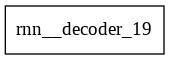

In [372]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_encoder_InceptionV3 + GRU + BahdanauAttention.png', show_shapes=True, show_layer_names=True)
plot_model(image_features_extract_model, to_file='model_image_features_extract_model_VGG16 + LSTM + BahdanauAttention.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='model_decoder_InceptionV3 + GRU + BahdanauAttention.png', show_shapes=True, show_layer_names=True)

In [373]:
encoder.summary()

Model: "cnn__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             multiple                  524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [374]:
decoder.summary()

Model: "rnn__decoder_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     multiple                  2560256   
_________________________________________________________________
gru_16 (GRU)                 multiple                  1575936   
_________________________________________________________________
dense_99 (Dense)             multiple                  262656    
_________________________________________________________________
dense_100 (Dense)            multiple                  5130513   
_________________________________________________________________
bahdanau_attention_12 (Bahda multiple                  394753    
Total params: 9,924,114
Trainable params: 9,924,114
Non-trainable params: 0
_________________________________________________________________


In [375]:
image_features_extract_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________